## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [ ]:
%matplotlib inline

import os
import sys
import copy
import multiprocessing

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.operations import create_visibility, sum_visibility
from arl.visibility.iterators import vis_timeslice_iter, vis_wslice_iter
from arl.util.testing_support import create_named_configuration

from matplotlib import pyplot as plt

from arl.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, create_empty_image_like, qa_image, smooth_image
from arl.image.iterators import raster_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *
from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW core configuration

In [ ]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [ ]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

Fill in the visibility with exact calculation of a number of point sources

In [ ]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1)
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            predict_skycomponent_visibility(vt, comp)
            insert_skycomponent(model, comp)
        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

In [ ]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Predict the visibility using the different approaches.

In [ ]:
processors = [predict_2d, predict_timeslice, predict_wslice, predict_facets, predict_wprojection]

for processor in processors:
    
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")   
    vtpredict = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                  weight=1.0, phasecentre=phasecentre,
                                 polarisation_frame=PolarisationFrame('stokesI'))

    vtpredict = processor(vtpredict, model, nprocessor=1, timeslice=1.0,
                          padding=2, oversampling=4, facets=8, wstep=10.0, wslice=10.0)
        
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=processor.__name__)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]-vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()

Make the image using the different approaches. We will evaluate the results using a number of plots:

- The recovered flux versus distance from phase centre. We show two forms: the result fitted and the result from a DFT at the expected position. The ideal result would blue and red dots overlaid.
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.
- The fitted flux versus the DFT flux. The ideal result is a straightline fitted: flux = DFT flux

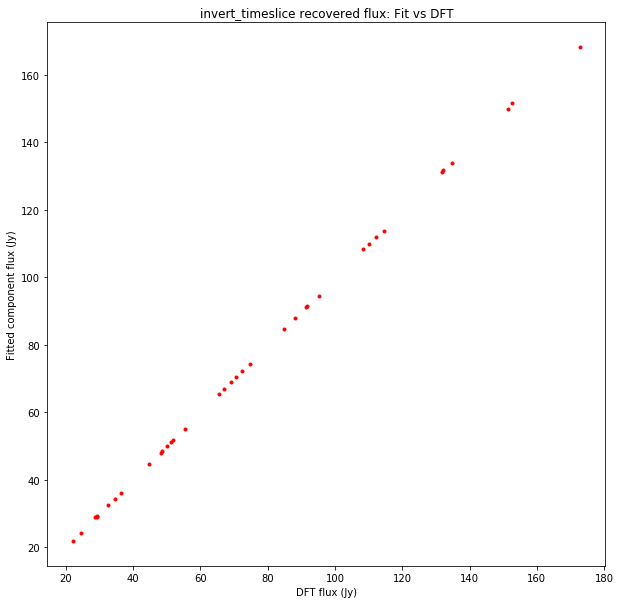

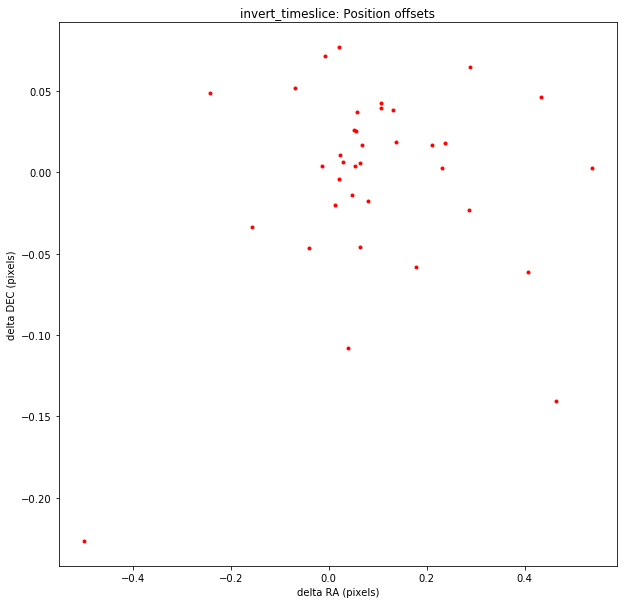

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_wslice: inverting using w

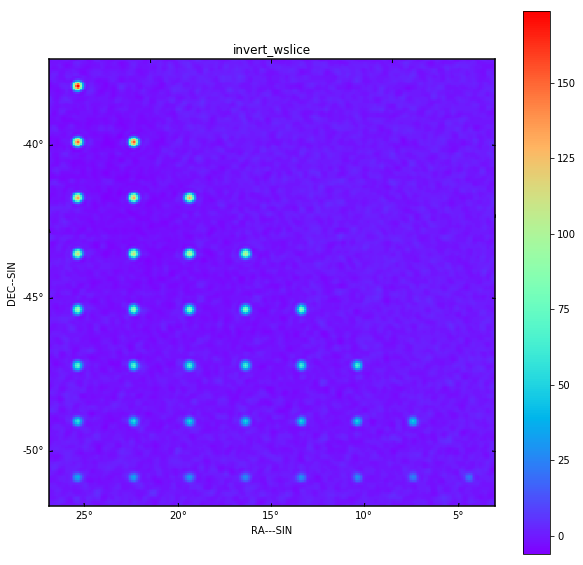

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wslice
	Data:
		shape: (1, 1, 256, 256)
		max: 173.923775334
		min: -6.15017410659
		rms: 6.52623838715
		sum: 3176.5818624
		medianabs: 1.13417138032
		median: -0.658465914564

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments
find_skycomponents: Identified 36 segments


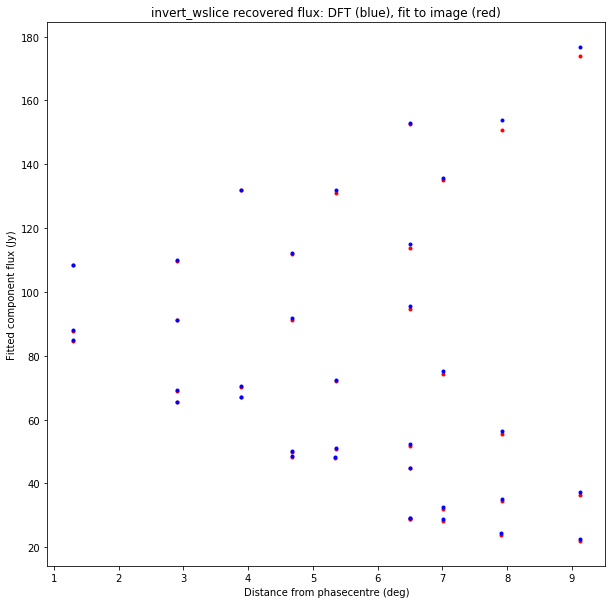

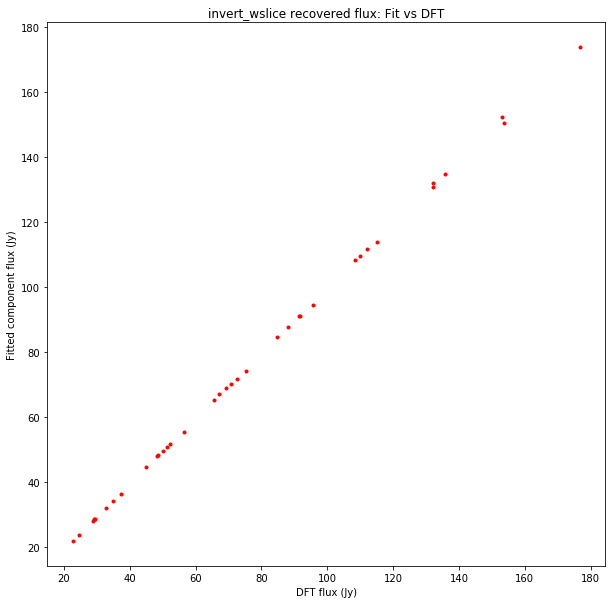

In [ ]:
processors = [invert_2d, invert_timeslice, invert_wslice, invert_facets, invert_wprojection]


for processor in processors:

    targetimage = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1)
    targetimage, sumwt = processor(vt, targetimage, timeslice='auto', padding=2, oversampling=4,
                                  facets=8, wstep=10.0, wslice=10.0)

    targetimage.data /= sumwt
    
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    print("Dirty Image %s" % 
          qa_image(targetimage, context="imaging-fits notebook, using processor %s" %(processor.__name__)))
    
    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' %(results_dir, processor.__name__))

    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)
    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        plt.plot(distance.deg, comp.flux[0,0], '.', color='r') 
        plt.plot(distance.deg, sum_visibility(vt, comp.direction)[0], '.', color='b')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.ylabel('Fitted component flux (Jy)')
    plt.title("%s recovered flux: DFT (blue), fit to image (red)" % (processor.__name__))
    plt.show()
    plt.clf()

    for comp in comps:
        plt.plot(sum_visibility(vt, comp.direction)[0], comp.flux[0,0], '.', color='r')
    plt.ylabel('Fitted component flux (Jy)')
    plt.xlabel('DFT flux (Jy)')
    plt.title("%s recovered flux: Fit vs DFT" % (processor.__name__))
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/targetimage.wcs.wcs.cdelt[0], 
                     (comps[i].direction.dec.value - ocomp.direction.dec.value)/targetimage.wcs.wcs.cdelt[1], 
                     '.', color='r')  

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % (processor.__name__))
        plt.show()